# GEONE - Variogram analysis and kriging for data in 3D (omni-directional in horizontal plane (first two main axes))

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:

- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [4]:
cov_model_ref = gn.covModel.CovModel3D(elem=[
    ('spherical', {'w':9.5, 'r':[18, 18, 2.5]}), # elementary contribution (different ranges: anisotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], alpha=0.0, beta=0.0, gamma=0.0, name='ref model (anisotropic)')

In [5]:
cov_model_ref

*** CovModel3D object ***
name = 'ref model (anisotropic)'
number of elementary contribution(s): 2
elementary contribution 0
    type: spherical
    parameters:
        w = 9.5
        r = [18, 18, 2.5]
elementary contribution 1
    type: nugget
    parameters:
        w = 0.5
angles: alpha = 0.0, beta = 0.0, gamma = 0.0 (in degrees)
    i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
    is obtained from the system Oxyz as follows:
        Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
        Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
        Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''
*****

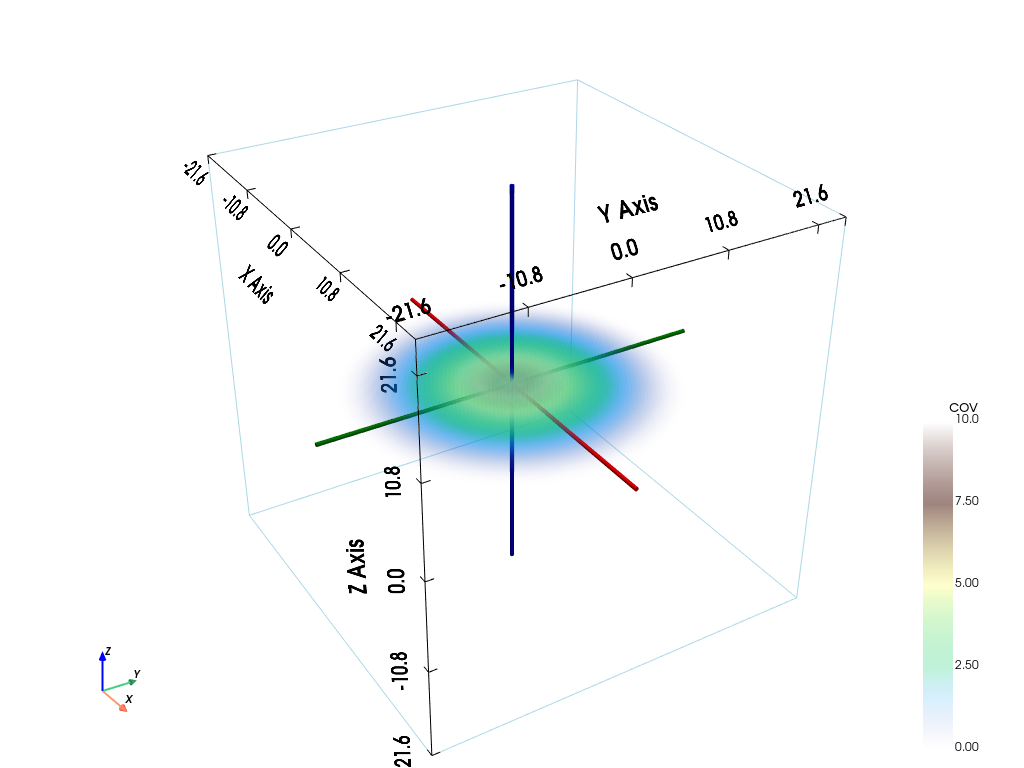

In [6]:
# Plot covariance model in 3D
pp = pv.Plotter()
# pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model_ref.plot_model3d_volume(plotter=pp)
cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

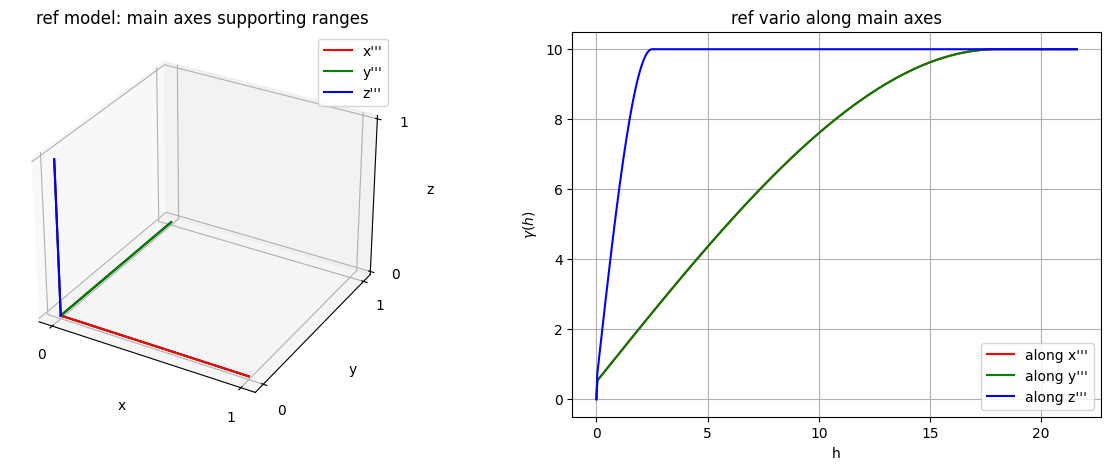

In [7]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(15,5))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')
plt.show()

Generate a gaussian random field in 3D (see function `geone.grf.grf3D`), and extract data points:

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

In [8]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
sx, sy, sz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(2223)
ref = gn.grf.grf3D(cov_model_ref, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), nreal=1) 
    # 4d-array of shape 1 x nz x ny x nx

# Extract n points from the reference simulation
n = 150 # number of data points
ind = np.random.choice(nx*ny*nz, size=n, replace=False) # indexes of extracted grid cells
iz = ind//(nx*ny) # indexes along z-axis
ii = ind%(nx*ny)
iy = ii//nx # indexes along y-axis
ix = ii%nx  # indexes along x-axis
xc = ox + (ix + 0.5)*sx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*sy # y-coordinates of data points (centers of the extracted grid cells)
zc = oz + (iz + 0.5)*sz # z-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*sx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*sy # y-coordinates of data points (within the extracted grid cells)
#zc = oz + (ind + np.random.random(n))*sz # z-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc, zc)).T # array of coordinates of data points (shape: n x 3)
v = ref[0].reshape(-1)[ind] # value at data points

In [9]:
# Preparation for plotting reference simulation and data points

# fill image (Img class from geone.img) for view
im_ref = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=ref)

# Color settings
cmap = 'terrain'

cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

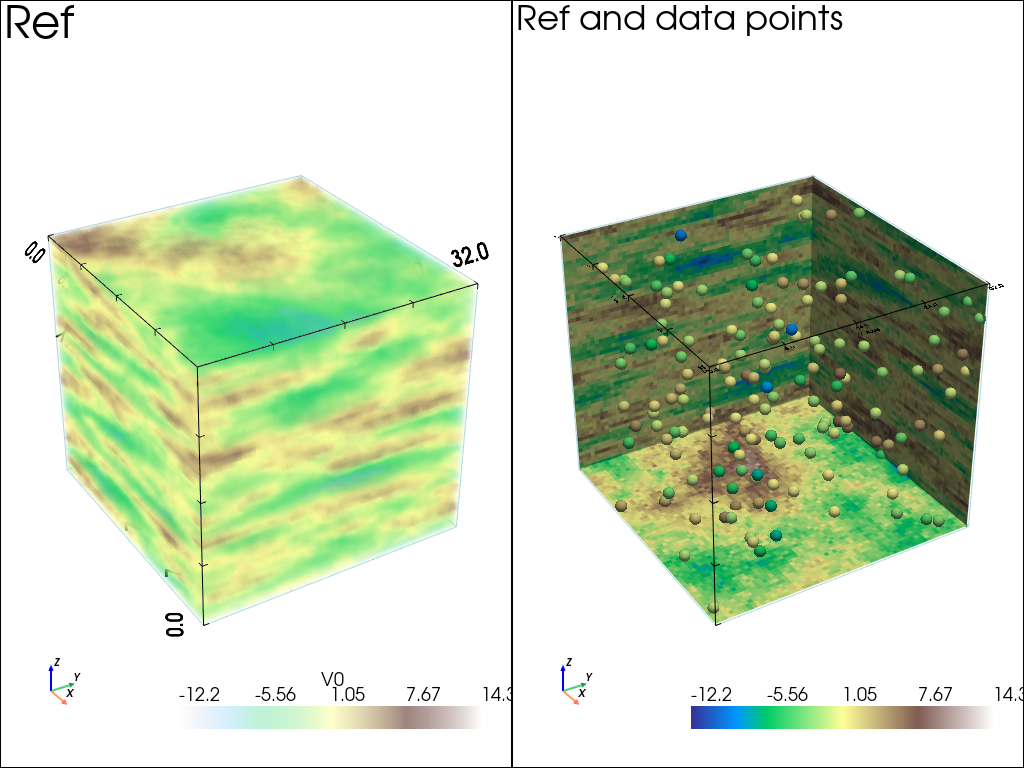

In [10]:
# Plot reference simulation and data points 

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_ref, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ref') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_ref, 
    plotter=pp, 
    slice_normal_x=ox+0.5*sx,
    slice_normal_y=oy+(ny-0.5)*sy,
    slice_normal_z=oz+0.5*sz,
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Ref and data points')

pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Start from a data set in 3D

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

Visualise the data set and the histogram of values.

In [11]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

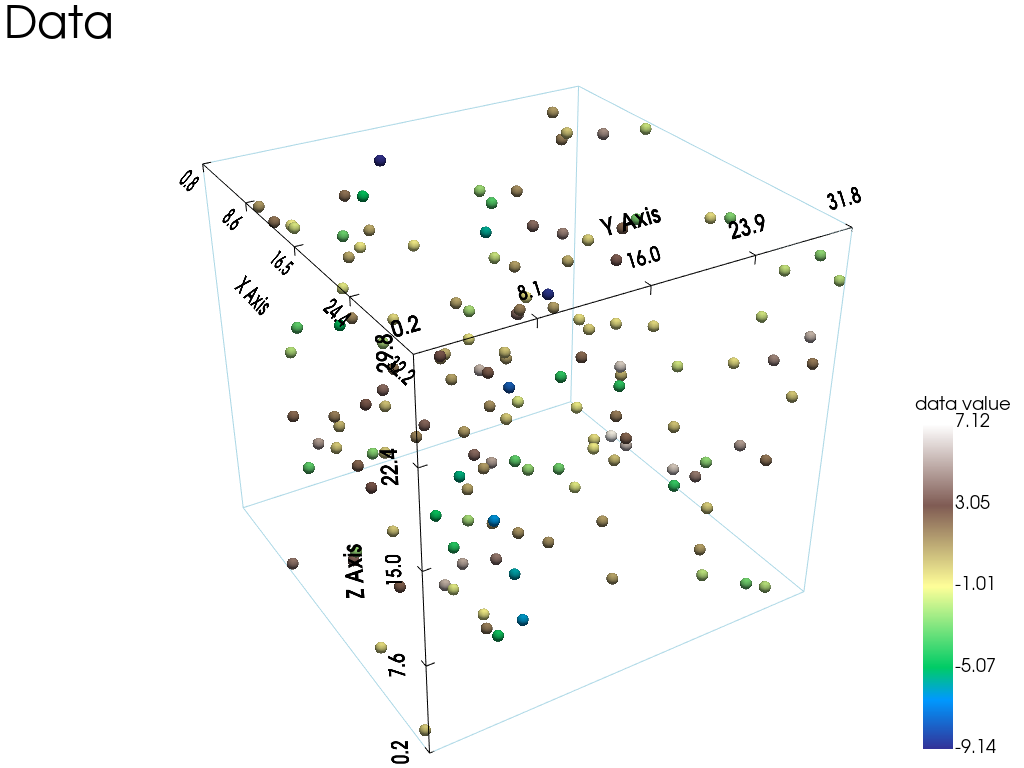

In [12]:
# Plot data points in 3D

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

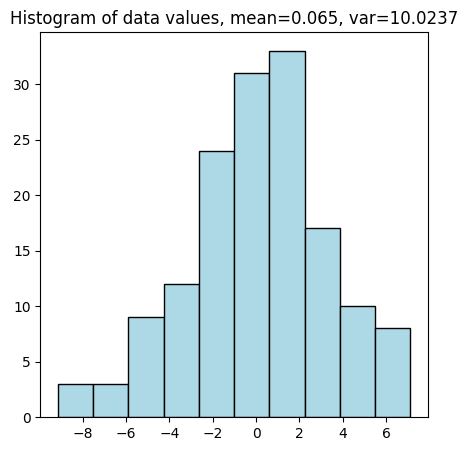

In [13]:
# Plot histogram of data values
plt.figure(figsize=(5,5))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Model fitting
The function `geone.covModel.covModel3D_fit` is used to fit a covariance model in 3D (class `geone.covModel.CovModel3D`).

The general case is illustrated in the notebook `ex_vario_analysis_data3D_2_general`, where the ranges along the three main axes are "independent". Here, we impose that the ranges along the first two main axes must be equal, to get an omni-directional model with respect to the first two main axes (i.e with any direction parallel to the plane spanned by the first two main axes). For that, the keyword argument `link_range12=True` is passed to the function `geone.covModel.covModel3D_fit`. 

For the other parameters, see the notebook `ex_vario_analysis_data3D_2_general`. However, note that specifying `link_range12=True`, meaning that the ranges along first two main axes are "linked", implies that:
- both ranges along the first two main axes in any elementary contribution of the 3D covariance model to optimize, must be set to the same value or be set for the optimization
- if `hmax` is specified, it's a sequence of 3 floats (or one float duplicated 3 times), corresponding to the three main axes, and the first two entries must be equal
- if the bounds for parameters to be optimized (keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)` passed to the function `curve_fit` from `scipy.optimize`), the bounds for the range along the second main must be removed (as this range is linked to the range of the first main axis)

In [14]:
cov_model_to_optimize = gn.covModel.CovModel3D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=0, beta=0, gamma=0, name='')

cov_model_opt, popt = gn.covModel.covModel3D_fit(x, v, cov_model_to_optimize, link_range12=True, #hmax=150,
    bounds=([ 0,  0,      0,  0,  0,      0,  0,  0,      0,  .1],  # min value for param. to fit
            [20, 30,     30, 20, 30,     30, 20, 30,     30,   2]), # max value for param. to fit
             # gaus. contr.,   sph. contr. ,   exp. contr. , nug., omitting range along 2nd main axis, because link_range12=True
    make_plot=False)
cov_model_opt

*** CovModel3D object ***
name = ''
number of elementary contribution(s): 4
elementary contribution 0
    type: gaussian
    parameters:
        w = 2.2164763816553226
        r = [np.float64(29.99999999864916), np.float64(29.99999999864916), np.float64(26.453081448145294)]
elementary contribution 1
    type: spherical
    parameters:
        w = 8.431756204888991
        r = [np.float64(11.920690452561649), np.float64(11.920690452561649), np.float64(2.352833477129777)]
elementary contribution 2
    type: exponential
    parameters:
        w = 0.0015061023079999006
        r = [np.float64(12.019257720766797), np.float64(12.019257720766797), np.float64(2.247287082327629)]
elementary contribution 3
    type: nugget
    parameters:
        w = 0.10001456910663975
angles: alpha = 0, beta = 0, gamma = 0 (in degrees)
    i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
    is obtained from the system Oxyz as follows:
        Oxyz      -- rotation of angle -alpha a

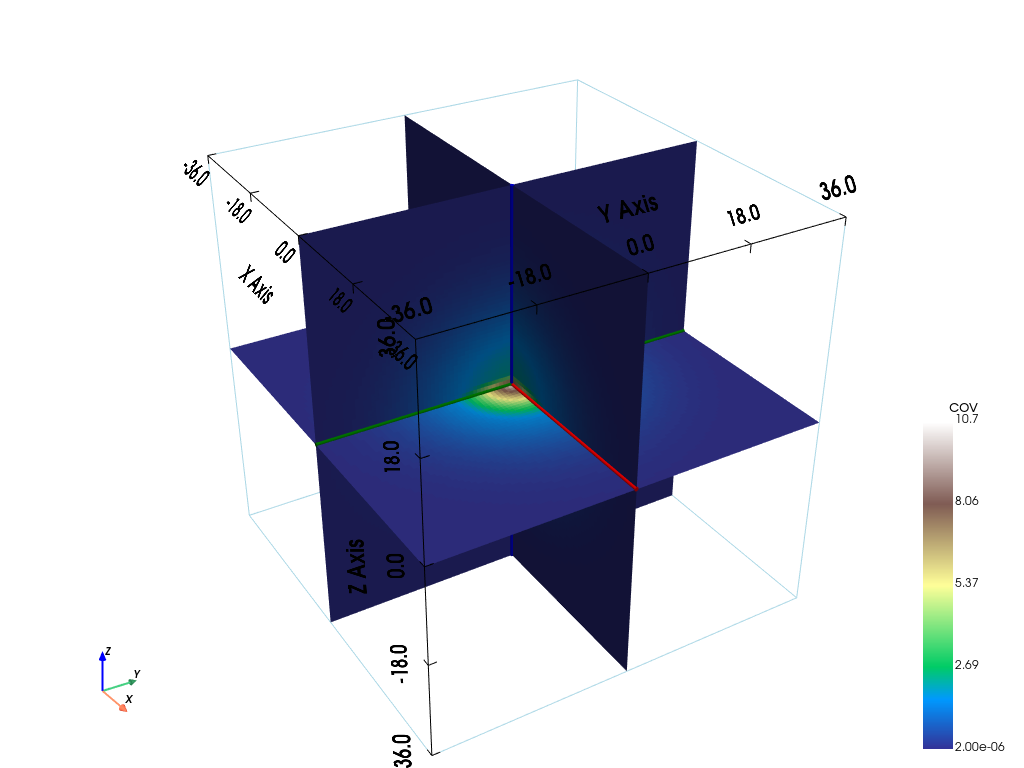

In [15]:
# Plot covariance model in 3D
#  slice orthogonal to main axes in a 3D block
pp = pv.Plotter()
# pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model_opt.plot_model3d_slice(plotter=pp)
cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

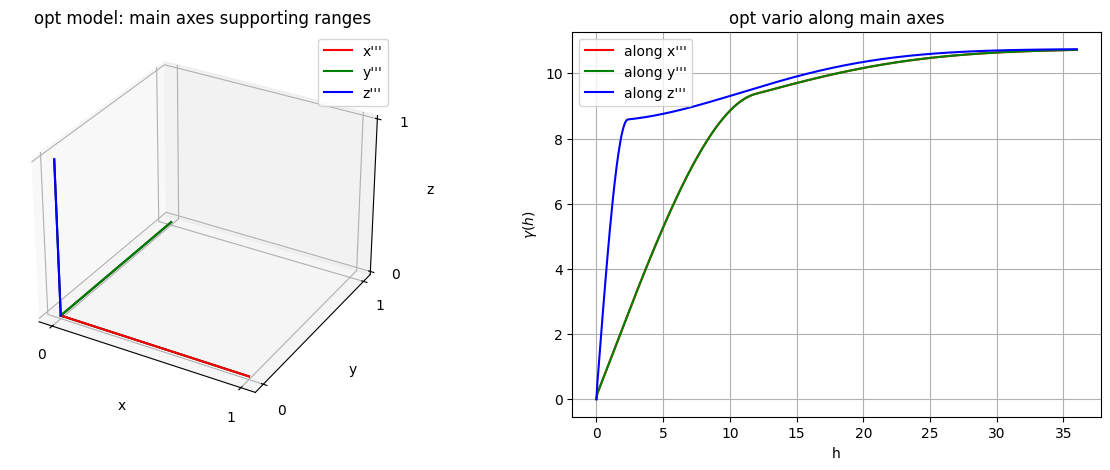

In [16]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(15,5))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')
plt.show()

### Check with the experimental variograms
The function `geone.covModel.variogramExp3D_omni_wrt_2_first_axes` computes two experimental variograms:
- the experimental omni-directional variogram with respect to the first two main axes (i.e with any direction parallel to the plane spanned by the first two main axes)
- the experimental directional variogram along the third main axis

The function `geone.covModel.variogramExp3D_omni_wrt_2_first_axes` is similar to the function `geone.covModel.variogramExp3D`, but the 
keyword arguments `tol_dist`, `tol_angle` and `hmax` are sequences of two floats (instead three), and determine which pairs of points are taken into account for computing the experimental variograms: `tol_dist[0]`, `tol_angle[0]`, `hmax[0]` are related to the experimental omni-directional variogram with respect to the first two main axes and the elements, and `tol_dist[1]`, `tol_angle[1]`, `hmax[1]` are related to the experimental directional variogram along the third main axis

Moreover, the functions `geone.covModel.variogramCloud3D_omni_wrt_2_first_axes` and `geone.covModel.variogramCloud3D` follow the same principles.

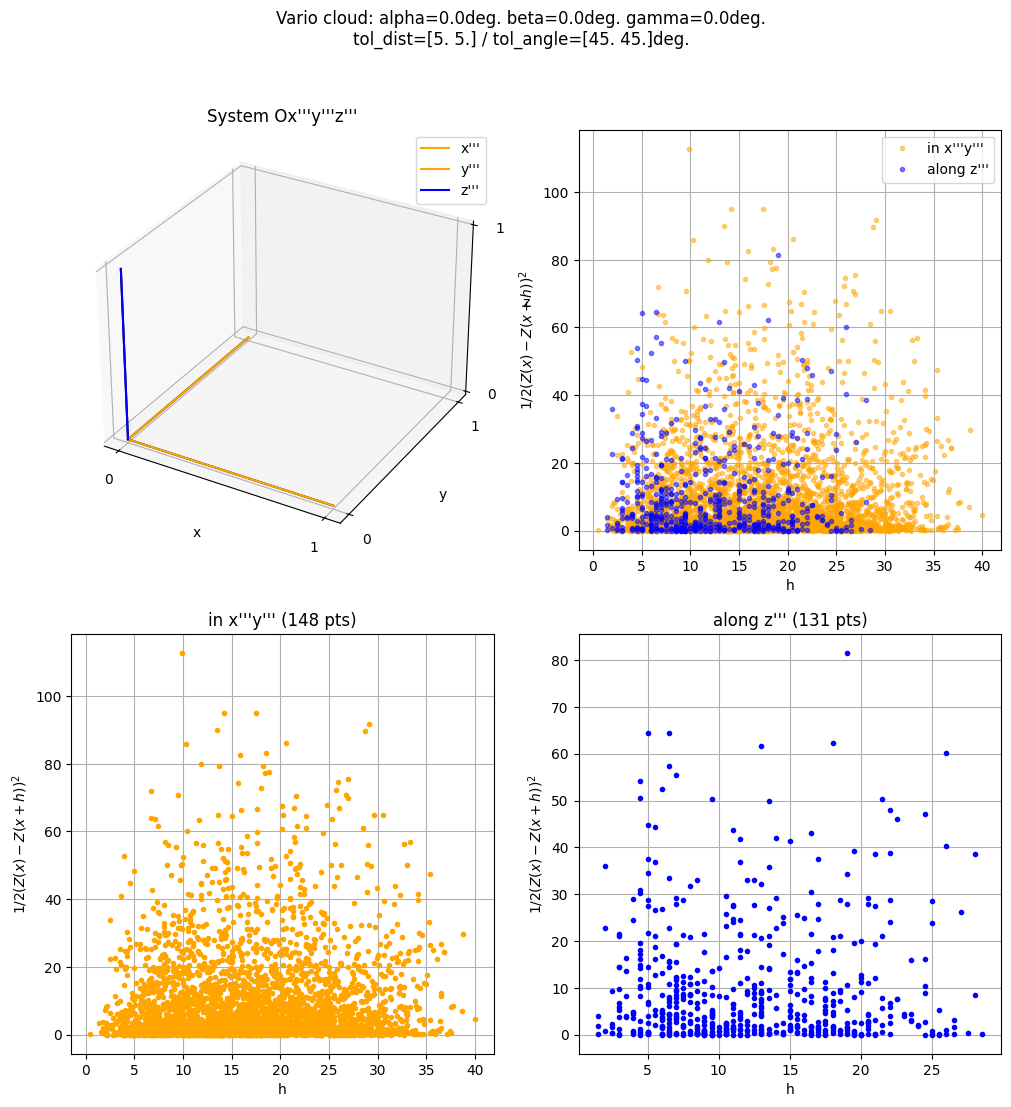

In [17]:
# Variogram clouds
(h12, g12, n12), (h3, g3, n3) = gn.covModel.variogramCloud3D_omni_wrt_2_first_axes(x, v, tol_dist=(5., 5.),
    alpha=0., beta=0., gamma=0., make_plot=True, figsize=(12,12))

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


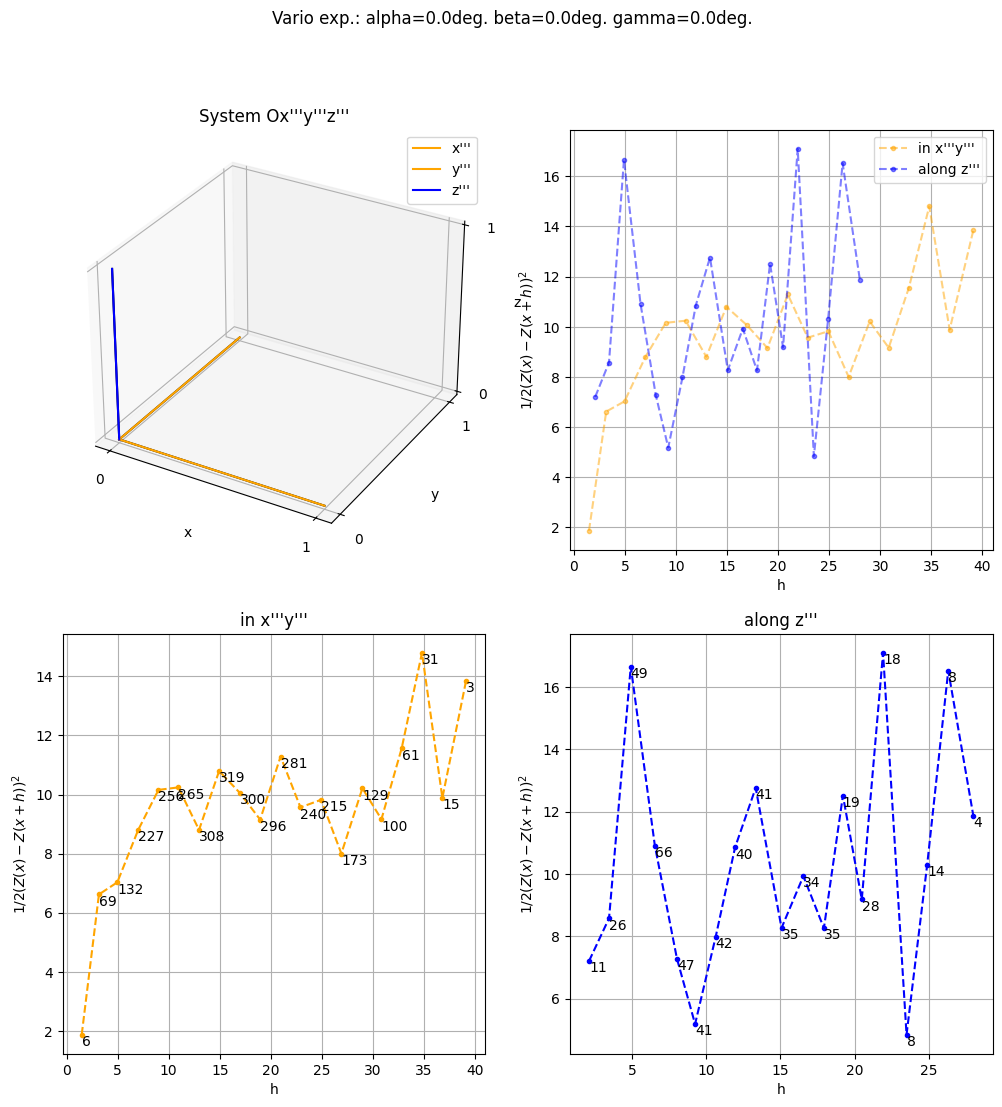

In [18]:
# Experimental variograms
(hexp12, gexp12, cexp12), (hexp3, gexp3, cexp3) = gn.covModel.variogramExp3D_omni_wrt_2_first_axes(x, v, tol_dist=(5., 5.),
    alpha=0., beta=0., gamma=0., ncla=(20,20), make_plot=True, figsize=(12,12))

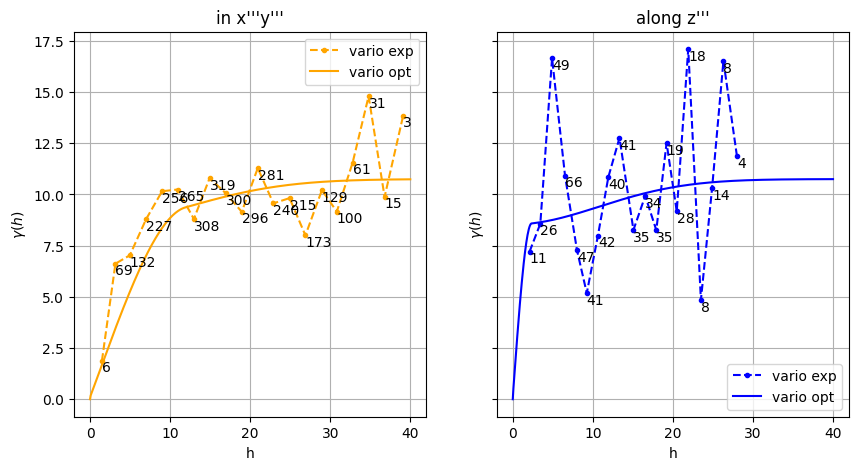

In [19]:
# Experimental variograms and fitted model
plt.subplots(1,2,figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp12, gexp12, cexp12, c='orange', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=40, c='orange', label='vario opt')
plt.legend()
plt.title("in x'''y'''")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp3, gexp3, cexp3, c='blue', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=3, hmax=40, c='blue', label='vario opt')
plt.legend()
plt.title("along z'''")

plt.show()

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. Here, a data set in 3D and a covariance model in 3D are given.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

----- CRPS (negative; the larger, the better) -----
   mean = -1.53
   def. = -0.7399
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9945
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.6401
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = -0.0005644 (should be close to 0)
   std      = 0.9771 (should be close to 1)
   skewness = 0.2811 (should be close to 0)
   excess kurtosis = 0.3595 (should be close to 0)


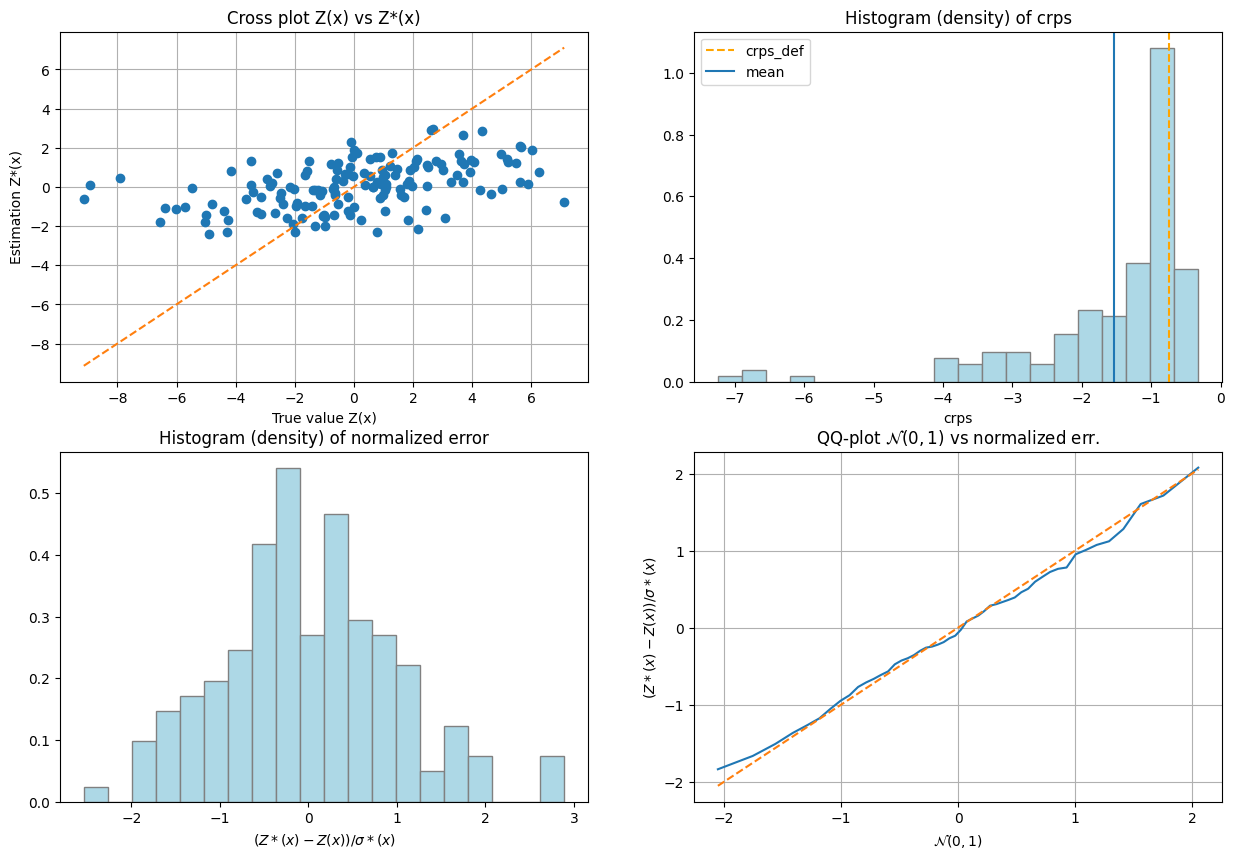

In [20]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'use_unique_neighborhood':True},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

**Note:** the following illustrations are similar to what is done in the jupyter notebook `ex_vario_analysis_data3D_1_omnidirectional`.


## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
See notebook `ex_vario_analysis_data1D_1.ipynb`.


In [21]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*sz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Ordinary kriging
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

Elapsed time: 3.4 sec


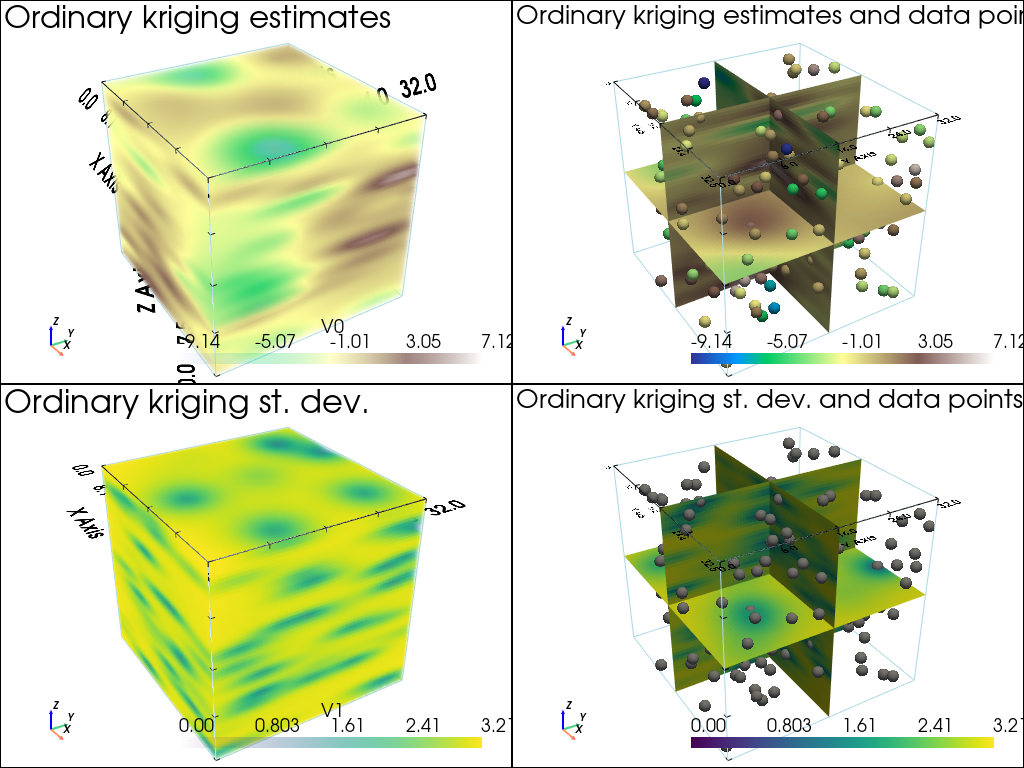

In [22]:
# Color settings
cmap = 'terrain'

cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ordinary kriging estimates') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Ordinary kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ordinary kriging st. dev.') # title

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text='Ordinary kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [23]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*sz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Simple kriging
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

Elapsed time: 2.8 sec


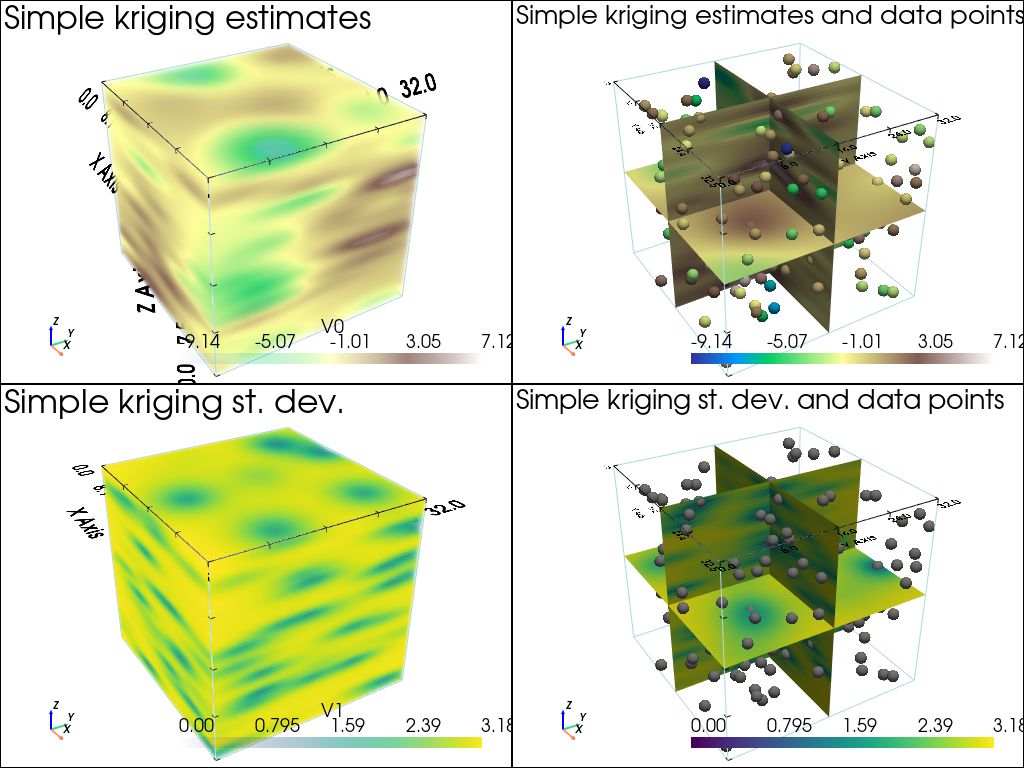

In [24]:
# Color settings
cmap = 'terrain'

cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Simple kriging estimates') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Simple kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    text='Simple kriging st. dev.') # title

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text='Simple kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Kriging estimation and simulation in a grid
The function above (`gn.covModel.krige` and `gn.covModel.sgs[_mp]`) should not be used for kriging and SGS in a regular grid. Use the dedicated functions (much faster):
- `geone.geosclassicinterface.estimate`: estimation (kriging) in a grid
- `geone.geosclassicinterface.simulate`: simulation (SGS) in a grid
- `geone.grf.krige<d>D`: estimation (kriging) in a `<d>`-dimensional grid
- `geone.grf.grf<d>D`: simulation (SGS) in a `<d>`-dimensional grid

*Note: the functions of the module `geone.grf` are based on "Fast Fourier Transform" and allow for simple kriging only, and do not handle error on data or inequality data.*

*Note: the function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper to run the functions above.*

See notebook `ex_vario_analysis_data1D_1.ipynb`.

### Estimation using the function `geone.covModel.krige`

In [25]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 3.2 sec


### Estimation using the function `geone.grf.krige3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [26]:
t1 = time.time()
im_grf = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                x=x, v=v,
                mode='estimation', algo='fft', output_mode='img')
# # Or:
# vu_grf, vu_std_grf = gn.grf.krige3D(
#                 cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                 x=x, v=v)
# im_grf = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu_grf, vu_std_grf)))
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krige3D: Computing circulant embedding...
krige3D: embedding dimension: 128 x 128 x 64
krige3D: Computing FFT of circulant matrix...
krige3D: Computing covariance matrix (rAA) for conditioning locations...
krige3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige3D: Computing rBA * rAA^(-1)...
krige3D: computing kriging estimates...
krige3D: computing kriging standard deviation ...
Elapsed time: 2 sec


### Estimation using the function `geone.geosclassicinterface.estimate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [27]:
t1 = time.time()
im_gci = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                x=x, v=v,
                mode='estimation', algo='classic', output_mode='img',
                method='simple_kriging', 
                nneighborMax=24,
                nthreads=8)
# # Or:
# estim_gci = gn.geosclassicinterface.estimate(
#                 cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                 x=x, v=v,
#                 method='simple_kriging', 
#                 nneighborMax=24,
#                 nthreads=8)
# im_gci = estim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate: Preprocessing data done: final number of data points : 150, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 22 sec


### Plot results of estimation

In [28]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

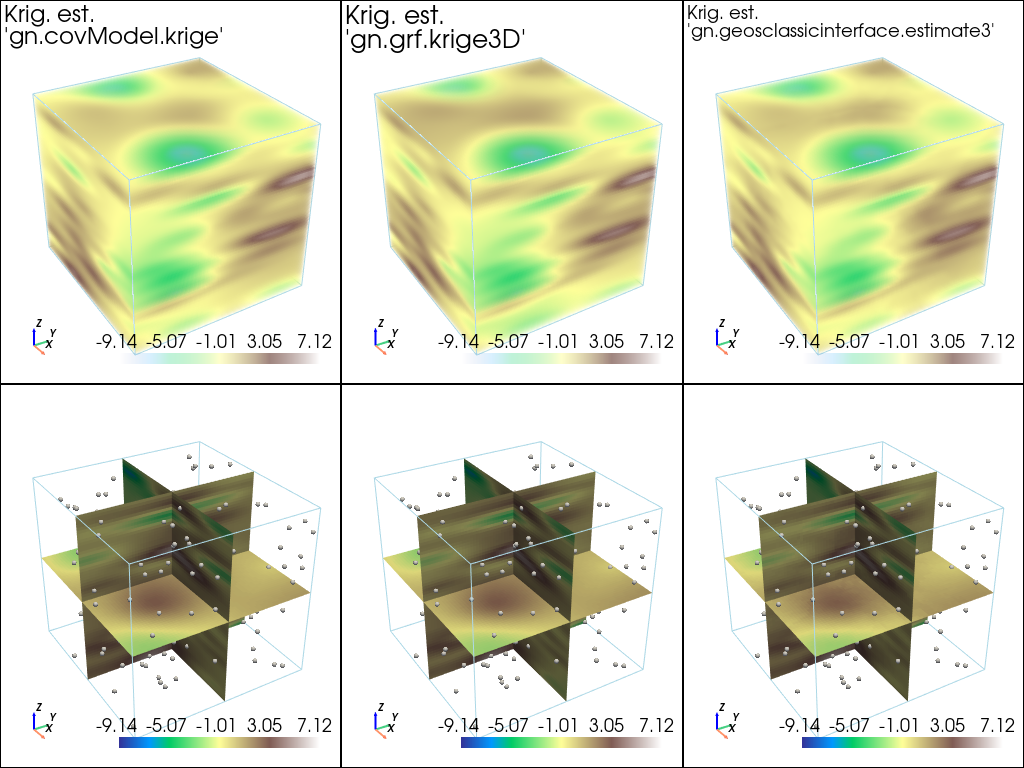

In [29]:
# Plot kriging estimates

# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.covModel.krige'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_grf, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.grf.krige3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_gci, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.geosclassicinterface.estimate3'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_grf, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_gci, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

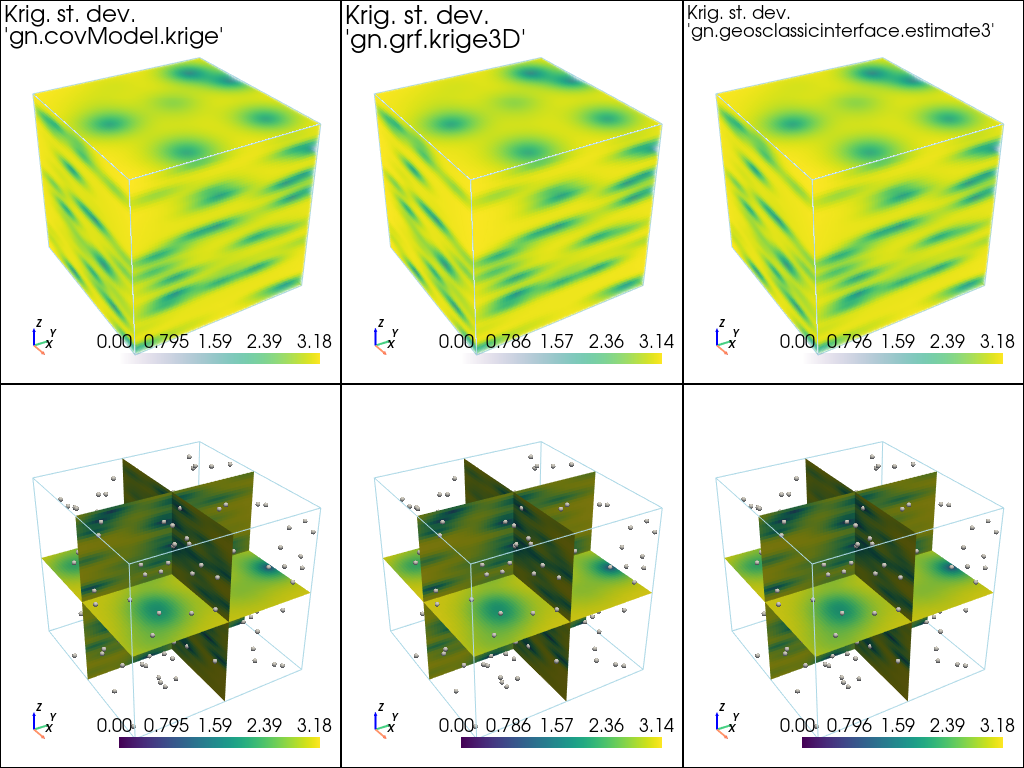

In [30]:
# Plot kriging standard deviation

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.covModel.krige'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_grf, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.grf.krige3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_gci, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.geosclassicinterface.estimate3'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_grf, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_gci, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [31]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                   = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                   = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                   = 2.4428291623291427
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = 1.6196250361470466
Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = 2.6212235377593887
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                   = 0.07001601398761537
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = 0.03304106379573791
Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = 0.07483839296869332


### Conditional simulation using the function `geone.grf.grf3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [32]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_grf = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                    x=x, v=v,
                    mode='simulation', algo='fft', output_mode='img',
                    nreal=nreal)
# # Or:
# sim_grf = gn.grf.grf3D(
#                     cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                     x=x, v=v,
#                     nreal=nreal)
# im_sim_grf = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim_grf)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
grf3D: Treatment of conditioning data...
grf3D: Computing covariance matrix (rAA) for conditioning locations...
grf3D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 3.9 sec


### Conditional simulation using the function `geone.geosclassicinterface.simulate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`, and specifying the computational resources (`nproc` and `nthreads_per_proc`).

In [33]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_gci = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                    x=x, v=v,
                    mode='simulation', algo='classic', output_mode='img',
                    method='simple_kriging',
                    nreal=nreal, 
                    nproc=4, nthreads_per_proc=4)
# # Or:
# sim_gci = gn.geosclassicinterface.simulate(
#                   cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                   x=x, v=v, 
#                   method='simple_kriging',
#                   nreal=nreal, 
#                   nproc=4, nthreads_per_proc=4)
# im_sim_gci = sim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate: Preprocessing data done: final number of data points : 150, inequality data points: 0
simulate: Computational resources: nproc = 4, nthreads_per_proc = 4, nproc_sgs_at_ineq = 16
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (20 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 4 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (4 process(es)) run complete
Elapsed time: 6 sec


### Plot some realizations and compare to the reference simulation

In [34]:
# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0]) 

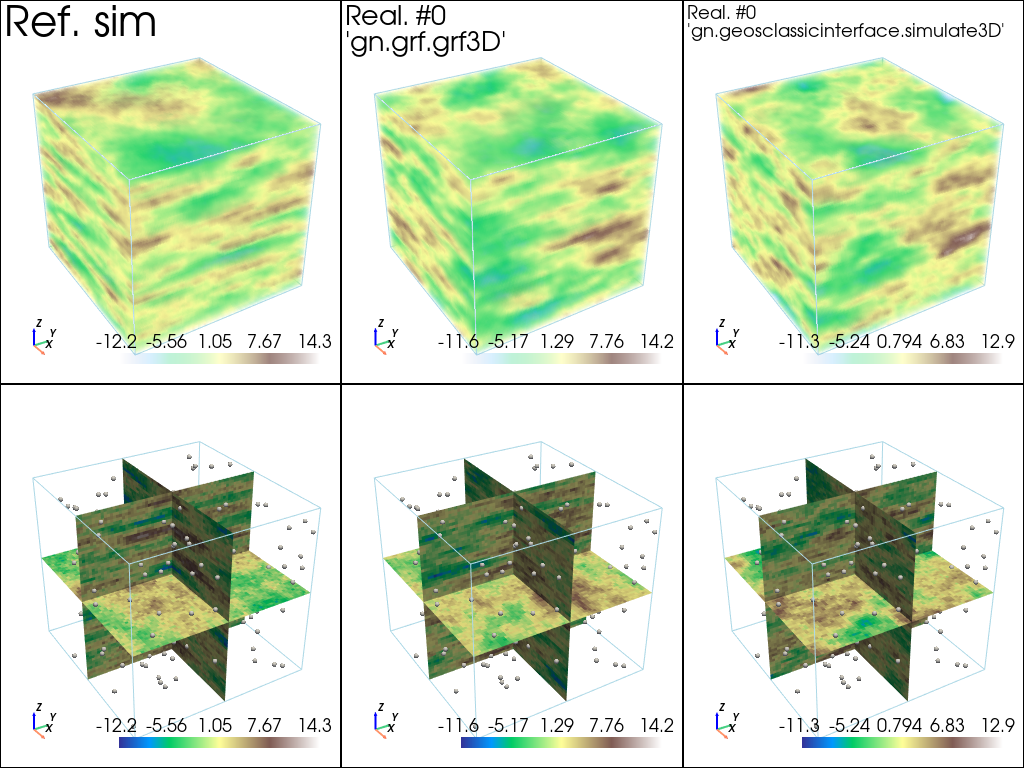

In [35]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_ref, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Ref. sim") # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_sim_grf, iv=0, 
    plotter=pp,
    cmap=cmap,
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Real. #0\n'gn.grf.grf3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_sim_gci, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Real. #0\n'gn.geosclassicinterface.simulate3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_ref, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_sim_grf, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_sim_gci, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

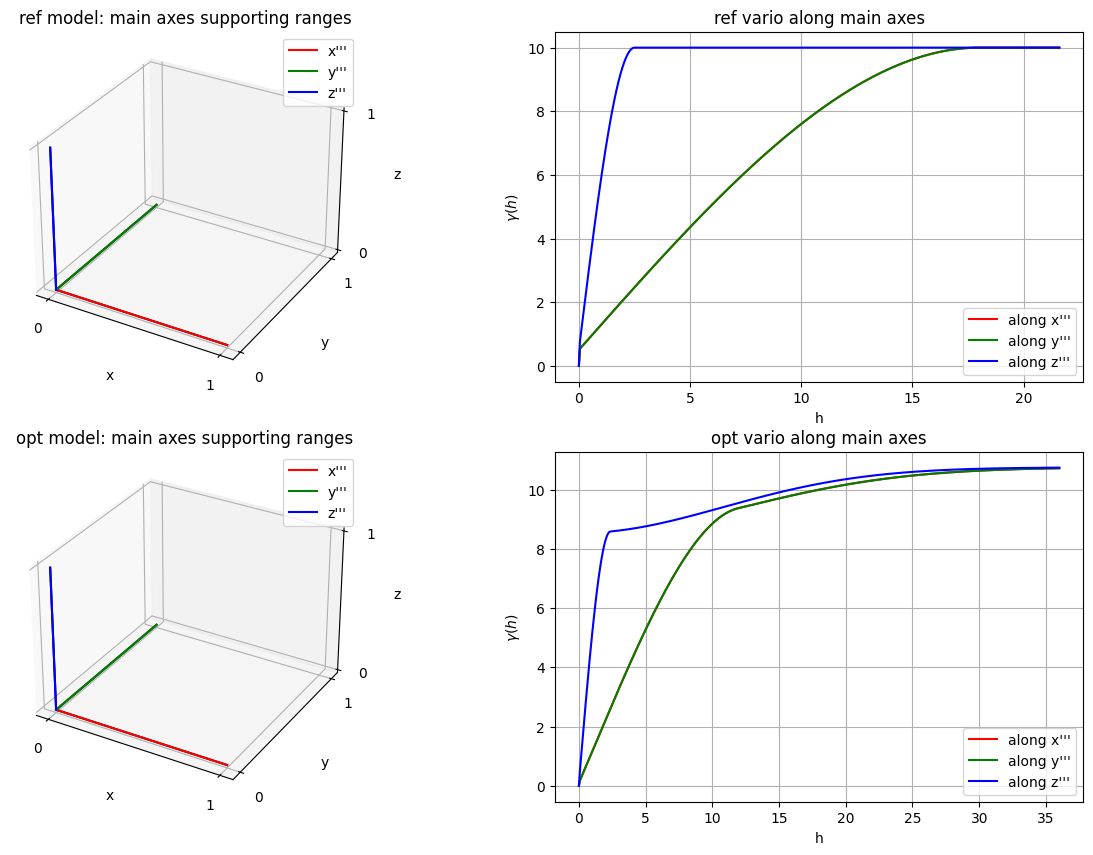

In [36]:
# Comparison of "optimal model" and "reference model"
fig = plt.figure(figsize=(15,10))

# ...plot main axes (ref model)
fig.add_subplot(2,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (ref model)
fig.add_subplot(2,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')

# ...plot main axes (opt model)
fig.add_subplot(2,2,3, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (opt model)
fig.add_subplot(2,2,4)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')

plt.show()